# Importazione delle librerie utilizzate

In [11]:
import skimage
import numpy as np

%matplotlib inline 
import matplotlib.pyplot as plt

from PIL import Image

# Disabilito il limite di caricamento per immagini di grandi dimensioni 
Image.MAX_IMAGE_PIXELS = None

import os

from skimage import data, filters, feature, measure, morphology, segmentation, color
from scipy.ndimage import distance_transform_edt
from sklearn.cluster import KMeans

import pandas as pd
import csv
import string
import shutil

# Definizione del metodo di divisione dell'immagine


In [12]:
def crop(source_image, height_box, width_box):
    # Assegna alle due variabili le dimensioni dell'immagine
    imgwidth, imgheight = source_image.size

    # Contatore per numerare le tiles nella cartella di destinazione
    k = 1
    
    for row in range(0, imgheight, height_box):
        for column in range(0, imgwidth, width_box):
            # Creo un riquadro con le coordinate ricavate dai dati
            box = (column, row, column + width_box, row + height_box)
                            
            # Mi assicuro di non creare tile che non vadano oltre le dimensioni massime dell'immagine, in modo da non inserire
            # quelle bande nere laterali e inferiori
            if(column + width_box < imgwidth and row + height_box < imgheight):
                # Creo un riquadro con le coordinate ricavate dai dati
                box = (column, row, column + width_box, row + height_box)
                
            elif (column + width_box > imgwidth and row + height_box < imgheight):
                # Creo un riquadro con le coordinate ricavate dai dati, ma l'ultima colonna tagliata
                box = (column, row, imgwidth, row + height_box)
                
            elif (column + width_box < imgwidth and row + height_box > imgheight):
                 # Creo un riquadro con le coordinate ricavate dai dati, ma l'ultima riga tagliata
                box = (column, row, column + width_box, imgheight)
                
            elif (column + width_box > imgwidth and row + height_box > imgheight):
                 # Creo un riquadro con le coordinate ricavate dai dati, ma l'ultima colonna e riga tagliata
                box = (column, row, imgwidth, imgheight)
                           
                
            # Utilizzo le precedenti coordinate per creare il tile
            tile = source_image.crop(box)

            # Creo la cartella di destinazione in caso non esista
            if not os.path.exists("Tiles"):
                os.makedirs("Tiles")
        
            # Salvo il riquadro (colonne x righe)
            tile.save("Tiles\\" + str(k) + "_[" + str(int(column/1500)) + "][" + str(int(row/1500)) + "].jp2")

            # Incremento il contatore
            k += 1


# Definizione del metodo di segmentazione: Watershade

In [13]:
def segmentation(nucleus, tile):
    # Andiamo adesso a levigare la superficie dei nuclei con il submodulo filters, eliminando il rumore dei dettagli
    # Applico un median filter di grandezza 5x5 sull'immagine
    nucleus_denoised = filters.median(nucleus, selem = np.ones((5, 5)))
    
    # Il prossimo passo è quello di trovare i bordi delle monete 
    # Useremo il Canny Edge Detector dal submodulo feature
    edges = skimage.feature.canny(nucleus, sigma = 3)
    
    # Per applicare l'algoritmo di watershed dobbiamo convertire i bordi nell'immagine in un landscape e per questo utilizziamo
    # la distance_transform implementata in scipy nel modulo ndimage
    dt = distance_transform_edt(~edges)
    
    # Troviamo la locazione delle fontane 
    local_max = feature.peak_local_max(dt, indices = False, min_distance = 5)
    
    # Richiamiamo la stessa funzione di prima, ma questa volta con indices = True 
    # Ciò ritornerà un array con la posizione di ogni picco, invece del picco visualizzato come in figura
    peak_idx = feature.peak_local_max(dt, indices = True, min_distance = 5)
    
    # Andiamo adesso a catalogare, numerare, ogni punto. Metodo usato dal Watershade per catalogare ogni regione intorno alla 
    # fontana
    markers = measure.label(local_max)
    
    # Chiamiamo la nostra funzione di watershade sul negativo della nostra distanza dt.
    # I bordi delle monete diventeranno i picchi, mentre il corpo della moneta e lo sfondo, diventeranno landscape
    labels = morphology.watershed(-dt, markers)
    
    # Regionprops sarà calcolato per ogni immagine che vediamo
    # Per ogni regionprops possiamo adesso calcolare l'area, il bounding box, l'area del bounding box, il centroide...
    regions = measure.regionprops(labels, intensity_image = nucleus)
    
    # Calcoliamo l'intensità media per ciascuna di queste regioni 
    region_means = [r.mean_intensity for r in regions]
    
    # Con questo if vado a controllare se l'immagine analizzata ha elementi di rilievo. In caso contrario, 
    # non procede nelle operazioni e non fa morire il programma   
    # TODO: La rilevazione di un'immagine piatta probabilmente può avvenire anche prima
    # TODO: Queste immagini piatte non compaiono all'interno delle statistiche finali, forse si potrebbe 
    #       far in modo da includerle con risultato zero 
    if region_means:
        # Chiediamo a KMeans che siamo interessati a due cluster
        model = KMeans(n_clusters = 2)
        
        # Convertiamo le informazioni ricavate in un array 
        region_means = np.array(region_means).reshape(-1, 1)
        model.fit(region_means)
        
        # Adesso calcoliamo il valore centrale dei due cluster trovati
        bg_fg_labels = model.predict(region_means)
        
        # Chiediamo adesso al nostro modello di predire le label per ogni regione 
        classified_labels = labels.copy()
        
        # Useremo poi la combinazione tra le nostre etichette predette con le diverse regioni e le riclassificheremo secondo le 
        # coordinate di ogni regione, e assegneremo un valore di background o foreground 
        for bg_fg, region in zip(bg_fg_labels, regions):
            classified_labels[tuple(region.coords.T)] = bg_fg
        
        result = color.label2rgb(classified_labels, image = nucleus)
        
        cells = counter(result, tile)
        return(cells)

# Definizione del metodo di conteggio

In [14]:
# Dopo aver definito i due cluster, adesso posso definire a quale categoria appartiene ogni sezione dell'immagine 

def counter(result, tile):
    
    rows, cols, bands = result.shape
    X = result.reshape(rows*cols, bands)
    
    kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
    labels_div = kmeans.labels_.reshape(rows, cols)

    nucleus = 0

    # Ho diviso ogni componente dell'immagine tra due sezioni. Lo sfondo dell'immagine dovrebbe essere classificato 
    # come unico elemento o comunque dovrebbe avere un valore di molto minore rispetto alla somma dei corpuscoli in evidenza
    for i in np.unique(labels_div):
        blobs = np.int_(morphology.binary_opening(labels_div == i))
        count = len(np.unique(measure.label(blobs))) - 1
        if count > nucleus:
            nucleus = count
            
    return(count)

# Scrittura su CSV dei conteggi

In [15]:
def csv_writer():
    # Lista dei file jp2 presenti nella cartella Tiles
    tiles = os.listdir(os.getcwd() + "\\Campione")
        
    with open('CSV\\mycsv.csv', "w") as csv_file:
        writer = csv.writer(csv_file, delimiter=',')
        writer.writerow(["object_name", "object_value"])
        
        # Algoritmi di segmentazione e di conteggio applicati ad ogni file nella cartella Tiles
        for tile in tiles[:]:
            # Caricamento dell'immagine in data
            nucleus = data.load(os.getcwd() + "\\Campione\\" + tile, True)

            # Segmentazione dei tile e conteggio dei nuclei
            cellule = segmentation(nucleus, tile)
            
            # Scrittura della stringa su file csv
            writer.writerow([tile,cellule])

# Ordinamento CSV in ordine di decrescente di numeri di nuclei 

In [16]:
def nucleus_sort():
    # Copio temporaneamnet il contenuto del file CSV a partire dalla seconda riga
    df = pd.read_csv('CSV\\mycsv.csv', header = 0)
    
    # Ordino i dati forniti dal CSV in modo decrescente
    df = df.sort_values('object_value', ascending=False)
    
    # Scrivo i dati raccolti e ordinati in un secondo file CSV
    df.to_csv('CSV\\sorted_mycsv.csv', index=False)

# Creazione di uno spazio ospitante le tiles con più nuclei cellulari

In [22]:
# Creazione della cartella che ospiterà le 50 immagini con più nuclei 
def dealing_tiles():
    df = pd.read_csv('CSV\\sorted_mycsv.csv')
    # Copio i dati presenti nel CSV ordinato, limitandomi ai nomi dei tile
    saved_column = df['object_name'] 
    
    index = 1
    
    # Creo la cartella di destinazione in caso non esista
    if not os.path.exists("Saved"):
        os.makedirs("Saved")
    
    # Copio ogni tile presente nel CSV nella cartella appena creata, rinominando il file in modo da assegnare la 
    # posizione nella cartella 
    for tile in saved_column:
        # I tile presenti nella nuova cartella devono essere i 50 più grandi 
        if(index <= 50):
            # Copio il tile
            shutil.copy(os.getcwd() + "\\Tiles\\" + tile, os.getcwd() + "\\Saved")
            # Rinomino
            shutil.move("Saved\\" + tile, "Saved\\" + str(index) + '_' + tile)
            index += 1

# Creazione dell'istogramma riassuntivo

In [18]:
def plot_histogram(csv_file):
    # Leggo i dati presenti nel CSV passato, assicurando che il carattere separatore sia la virgola, che l'header sia 
    # presente e quindi evitato
    data = pd.read_csv(csv_file, sep = ',', header = 0, index_col = 0)

    # Specifico il tipo di istogramma (a barre)
    data.plot(kind = 'bar')
    
    # Specifico le assi del grafico
    plt.ylabel('Frequency')
    plt.xlabel('Nucleus')
    
    # Do un titolo all'istogramma
    plt.title('Cell count')

    plt.show()

# Applicazione degli algoritmi

In [ ]:
# Apertura dell'immagine
sample_image = Image.open("Sample\\striscio_completo.jp2")

In [ ]:
# Divisione di tile delle immagini
crop(sample_image, 1500, 1500)

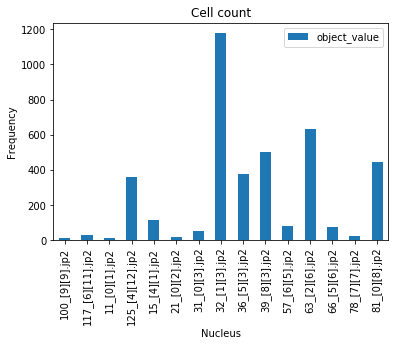

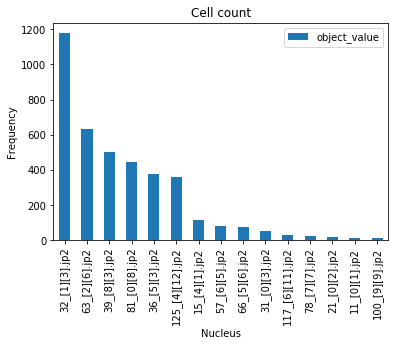

In [23]:
# Inizio delle operazioni e scrittura su CSV
# csv_writer()

# Plot del grafico
plot_histogram("CSV\\mycsv.csv")

# Ordino il file csv
nucleus_sort()

# Plot del grafico
plot_histogram("CSV\\sorted_mycsv.csv")

# Spostamento in una cartella separata dei tiles contenenti più nuclei e successiva catalogazione
dealing_tiles()